In [1]:
import os
#os.environ["NUMBA_DISABLE_JIT"] = "1"

import numpy as np
import pandas as pd
from GenerateParcelData import generate_data_one_simulation
import matplotlib.pyplot as plt
import pyrcel
from PySDM import Formulae
from MyParcelSimulation import MyParcelSimulation
from MyParcelSettings import MyParcelSettings
from PySDM.physics import si
from PySDM.initialisation.spectra import Lognormal

pd.options.display.max_columns = None

In [2]:
(mode_N,
    mode_mean,
    mode_stdev,
    mode_kappa,
    velocity,
    initial_temperature,
    initial_pressure,
    mac,
) = (2.206272267739369e9,8.150602088602004e-8,1.692725733125517,1.1920667635546394,0.0482689289197855,261.0026942744338,70887.79875482956,1)
# (condensation failed)
# (40233789.92354,1.1669322087438114e-09,1.7322676373747328,0.1885611585360898,0.0143756504108188,296.50590490254416,76309.09460546204,1)


In [3]:
N_SD = 100
DZ_PARCEL = 1 * si.m
Z_MAX_PARCEL = 1000 * si.m

dt = DZ_PARCEL / velocity
t_max = Z_MAX_PARCEL / velocity

In [ ]:
# pyrcel_aerosols = [pyrcel.AerosolSpecies("mode1", distribution=pyrcel.Lognorm(mode_mean * 1e6, mode_stdev, mode_N / 1e6),
#                                              kappa=mode_kappa, bins=N_SD)]
# pyrcel_model = pyrcel.ParcelModel(pyrcel_aerosols, velocity, initial_temperature, 0, initial_pressure, console=True)

# parcel_out, aerosol_out = pyrcel_model.run(t_end=t_max, output_dt=dt, solver_dt=dt, solver="cvode", terminate=True)


In [27]:
settings = MyParcelSettings(
        dt=20 * si.s,
        n_sd_per_mode=(N_SD,),
        aerosol_modes_by_kappa={
            mode_kappa: Lognormal(
                norm_factor=mode_N, m_mode=mode_mean, s_geom=mode_stdev
            )
        },
        vertical_velocity=velocity,
        initial_pressure=initial_pressure,
        initial_temperature=initial_temperature,
        initial_relative_humidity=1,
        t_max=Z_MAX_PARCEL / velocity,
        formulae=Formulae(constants={"MAC": mac}),
)
simulation = MyParcelSimulation(settings, dt_cond_range=(1e-3 * si.s, 1 * si.s))

In [22]:
radii = settings.formulae.trivia.radius(np.array(simulation.particulator.attributes["volume"]))
dry_radii = settings.formulae.trivia.radius(np.array(simulation.particulator.attributes["dry volume"]))
multiplicities = np.array(simulation.particulator.attributes["n"])

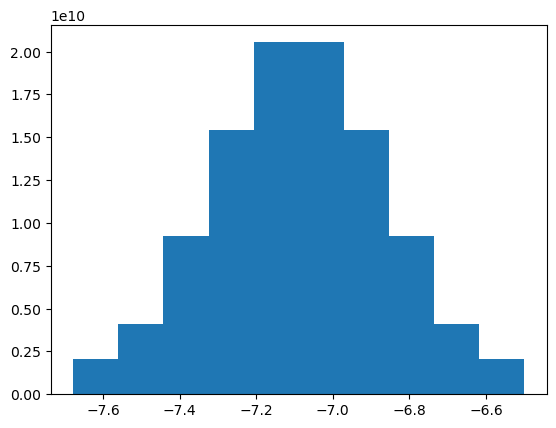

In [8]:
plt.hist(np.log10(dry_radii), weights=multiplicities, bins=10);

In [28]:
results = simulation.run()

....................................................................................................................................

In [29]:
products2 = results["products"]

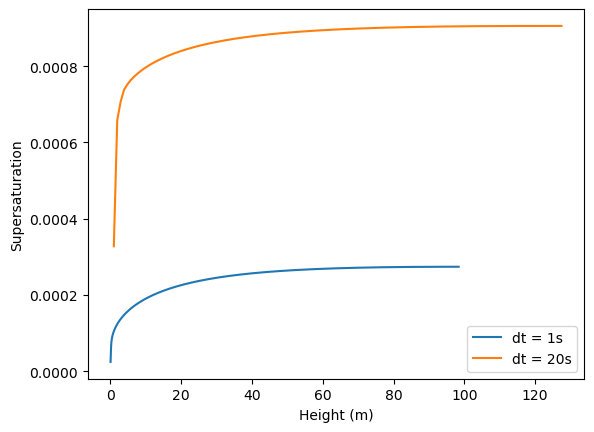

In [32]:
plt.xlabel("Height (m)")
plt.ylabel("Supersaturation")
plt.plot(products1["time"] * velocity, products1["S_max"], label="dt = 1s")
plt.plot(products2["time"] * velocity, products2["S_max"], label="dt = 20s")
plt.legend();

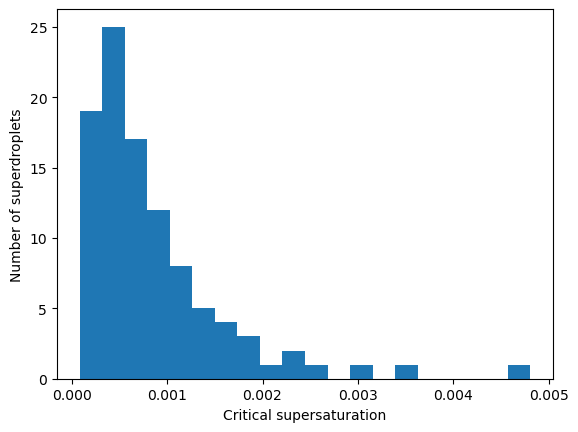

In [46]:
plt.xlabel("Critical supersaturation")
plt.ylabel("Number of superdroplets")
plt.hist(np.array(simulation.particulator.attributes["critical supersaturation"]) - 1, bins=20);

In [50]:
df = pd.DataFrame(products2)

In [51]:
df["ARG_act_frac_pyrcel"] = df.apply(
        lambda row: pyrcel.arg2000(
            V=velocity,
            T=initial_temperature,
            P=initial_pressure,
            accom=mac,
            mus=[mode_mean * 1e6],
            sigmas=[mode_stdev],
            Ns=[mode_N / 1e6],
            kappas=[mode_kappa],
        )[2][0],
        axis=1,
    )

In [52]:
df

,time,RH,T,p,vapor_mix_ratio,water_mix_ratio,S_max,act_frac_product,act_rate,act_frac_S,act_frac_V,mode_wet_radius_mean,mode_wet_radius_stdev,ARG_act_frac_pyrcel
0,20.0,1.000328,260.994661,70879.162178,0.002125,0.000048,0.000328,0.21,0.000000e+00,0.21,0.00,7.382440e-07,2.203572,0.009839
1,40.0,1.000361,260.987682,70870.474778,0.002124,0.000049,0.000659,0.53,0.000000e+00,0.53,0.00,7.443076e-07,2.211026,0.009839
2,60.0,1.000391,260.980409,70861.399195,0.002123,0.000050,0.000707,0.56,0.000000e+00,0.56,0.00,7.491793e-07,2.218351,0.009839
3,80.0,1.000404,260.973176,70852.300457,0.002122,0.000051,0.000738,0.58,0.000000e+00,0.58,0.00,7.534083e-07,2.225350,0.009839
4,100.0,1.000415,260.965936,70843.182201,0.002121,0.000052,0.000753,0.59,0.000000e+00,0.59,0.00,7.571080e-07,2.231936,0.009839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,2560.0,1.000554,260.072835,69727.336549,0.002005,0.000168,0.000906,0.68,0.000000e+00,0.68,0.03,8.498379e-07,2.521883,0.009839
128,2580.0,1.000554,260.065527,69718.318781,0.002004,0.000169,0.000906,0.68,0.000000e+00,0.68,0.03,8.500084e-07,2.522980,0.009839
129,2600.0,1.000554,260.058218,69709.301892,0.002003,0.000170,0.000906,0.68,0.000000e+00,0.68,0.03,8.501762e-07,2.524068,0.009839
130,2620.0,1.000554,260.050908,69700.285880,0.002002,0.000171,0.000906,0.68,0.000000e+00,0.68,0.03,8.503414e-07,2.525147,0.009839
